#Задача 1

Оставил все по прежнему, датасет не добавлял, тк тут заданы четкие условия

1. Разработать программу решения производственной задачи. Цех может производить стулья и столы. На производство стула идет 5 единиц материала, на производство стола – 20 единиц. Для изготовления стула требуется 10 человеко-   часов, стола – 15 Имеется 400 единиц материала и 450 человеко-часов. Прибыль при производстве стула – 45 у.е., при производстве стола – 80 у.е. Сколько надо сделать стульев и столов, чтобы получить максимальную прибыль?

##с датасетом

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab1.csv')
dataset.head()

,Chairs,Tables,Material,Man-Hours,Profit
0,0,20,400,300,1600
1,1,19,395,295,1535
2,2,18,390,290,1480
3,3,17,385,285,1425
4,4,16,380,280,1370


In [8]:
import pandas as pd
import random

file_path = 'lab1.csv'
data = pd.read_csv(file_path)

materials = data['Material'].sum()
hours_ludi = data['Man-Hours'].sum()

def calculate_profit(individual):
    x, y = individual
    # Находим соответствующие записи в датасете
    record = data[(data['Chairs'] == x) & (data['Tables'] == y)]
    if not record.empty:
        return record['Profit'].values[0]
    return 0

def random_change(individual):
    x, y = individual
    if random.random() < 0.5:
        x = max(0, x + random.choice([-1, 1]))
    else:
        y = max(0, y + random.choice([-1, 1]))
    return (x, y)

def mix_parents(parent1, parent2):
    return (parent1[0], parent2[1])

def evolutionary_algorithm(population_size, generations):
    population = [(random.choice(data['Chairs']), random.choice(data['Tables'])) for _ in range(population_size)]

    for _ in range(generations):
        population = sorted(population, key=calculate_profit, reverse=True)
        new_gen = population[:population_size // 2]

        while len(new_gen) < population_size:
            p1, p2 = random.sample(new_gen, 2)
            offspring = mix_parents(p1, p2)
            offspring = random_change(offspring)
            new_gen.append(offspring)

        population = new_gen

    best_result = max(population, key=calculate_profit)
    return best_result, calculate_profit(best_result)

# Запускаем эволюционный алгоритм
solution, profit = evolutionary_algorithm(population_size=100, generations=200)
print(f"Оптимальное решение: стулья = {solution[0]}, столы = {solution[1]}, Прибыль: {profit} у.е.")


Оптимальное решение: стулья = 0, столы = 20, Прибыль: 1600 у.е.


#Задача 2

2. Разработать программу решения задачи раскроя. Найти оптимальный вариант раскроя некоторого количества рулонов бумаги фиксированной ширины для различных заказчиков (которым нужны различные количества рулонов различной ширины), минимизировав при этом отходы.

##с датасетом

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab2.csv', sep=";")
dataset.head()

,Roll_Width,Client_ID,Order_Width,Order_Length,Quantity
0,100,1,40,100,10
1,100,2,30,200,15
2,100,3,50,150,5
3,100,4,60,80,20
4,100,5,10,300,8


In [59]:
import pandas as pd

dataset = pd.read_csv('lab2.csv', sep=";")
dataset.head()

class Zapros:
    def __init__(self, width_needed, amount):
        self.width_needed = width_needed
        self.amount = amount

class RulonTkani:
    def __init__(self, total_width):
        self.total_width = total_width
        self.available_width = total_width

def vichisleniya(zaprosy, rulon):
    fulfilled_requests = []
    for zapros in zaprosy:
        while zapros.amount > 0 and rulon.available_width >= zapros.width_needed:
            rulon.available_width -= zapros.width_needed
            zapros.amount -= 1
            fulfilled_requests.append(zapros.width_needed)

    return rulon.available_width, fulfilled_requests

def izgotovleniye(filename):
    # Загружаем данные из CSV-файла
    data = pd.read_csv('lab2.csv', sep=';')

    # Для примера используем только ширину рулона из первого ряда
    rulon_total_width = data['Roll_Width'].iloc[0]

    # Создаем список запросов на основе данных из CSV
    zaprosy = []
    for index, row in data.iterrows():
        zaprosy.append(Zapros(row['Order_Width'], row['Quantity']))

    rulon = RulonTkani(rulon_total_width)

    print(f"Исходная ширина рулона: {rulon.total_width}")

    remaining_width, fulfilled_requests = vichisleniya(zaprosy, rulon)

    print(f"Использованные размеры: {fulfilled_requests}")
    print(f"Оставшаяся ширина: {remaining_width}")

if __name__ == "__main__":
    izgotovleniye('lab2.csv')


Исходная ширина рулона: 100
Использованные размеры: [40, 40, 10, 10]
Оставшаяся ширина: 0


#Задача 3

3. Разработать программу решения транспортной задачи. Составить оптимальный план перевозок между N складами и K магазинами, при котором стоимость перевозок будет минимальна. Известна потребность в товаре каждым магазином, наличие товара на складах и стоимость перевозки единицы продукции с каждого склада до каждого магазина.

##с датасетом

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab3.csv', sep=";")
dataset.head()

,Warehouse,Store,Transport Cost,Store Demand,Warehouse Stock
0,Warehouse_1,Store_1,45414.0,30,150
1,Warehouse_1,Store_2,5.0,40,150
2,Warehouse_1,Store_3,45416.0,20,150
3,Warehouse_1,Store_4,3.0,25,150
4,Warehouse_1,Store_5,45413.0,10,150


In [67]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog

def transportnaya_zadacha(zatraty, zapas, potrebnost):
    kol_istochnikov, kol_napravleniy = zatraty.shape

    if sum(zapas) != sum(potrebnost):
        print("Сумма запасов не равна сумме потребностей")
        return None

    c = zatraty.flatten()
    A_ravno = []
    b_ravno = []

    for i in range(kol_istochnikov):
        stroka = [1 if j // kol_napravleniy == i else 0 for j in range(kol_istochnikov * kol_napravleniy)]
        A_ravno.append(stroka)
        b_ravno.append(zapas[i])

    for j in range(kol_napravleniy):
        stolb = [1 if j % kol_napravleniy == j else 0 for j in range(kol_istochnikov * kol_napravleniy)]
        A_ravno.append(stolb)
        b_ravno.append(potrebnost[j])

    A_ravno = np.array(A_ravno)
    b_ravno = np.array(b_ravno)

    res = linprog(c, A_eq=A_ravno, b_eq=b_ravno, method='highs')

    if res.success:
        optimalnaya_stoimost = res.fun
        optimalnaya_raspredelenie = res.x.reshape((kol_istochnikov, kol_napravleniy))
        return optimalnaya_stoimost, optimalnaya_raspredelenie
    else:
        print("Нет решения, ", res.message)
        return None

def glavnyy():
    # Загрузка данных из CSV с указанием разделителя
    data = pd.read_csv('lab3.csv', sep=';')

    # Получение числа источников и направлений
    warehouses = data['Warehouse'].unique()
    stores = data['Store'].unique()

    kol_istochnikov = len(warehouses)
    kol_napravleniy = len(stores)

    # Подготовка массивов
    zapas = np.array(data.groupby('Warehouse')['Warehouse Stock'].first())
    potrebnost = np.array(data.groupby('Store')['Store Demand'].first())

    # Проверяем суммы запасов и потребностей
    total_zapas = zapas.sum()
    total_potrebnost = potrebnost.sum()
    print(f"Общая сумма запасов: {total_zapas}, Общая сумма потребностей: {total_potrebnost}")

    if total_zapas != total_potrebnost:
        print("Сумма запасов не равна сумме потребностей.")
        return None

    # Формирование матрицы затрат
    zatraty = np.zeros((kol_istochnikov, kol_napravleniy))
    for index, row in data.iterrows():
        i = np.where(warehouses == row['Warehouse'])[0][0]
        j = np.where(stores == row['Store'])[0][0]
        zatraty[i][j] = row['Transport Cost']

    # Решение транспортной задачи
    rezultat = transportnaya_zadacha(zatraty, zapas, potrebnost)

    if rezultat:
        optimalnaya_stoimost, optimalnaya_raspredelenie = rezultat
        print(f"Минимальные затраты: {optimalnaya_stoimost}")
        print("Оптимальный план перевозок:")
        print(optimalnaya_raspredelenie)
    else:
        print("Нет решения")

if __name__ == "__main__":
    glavnyy()


Общая сумма запасов: 540, Общая сумма потребностей: 125
Сумма запасов не равна сумме потребностей.


#Задача 4

4. Разработать программу поиска минимального остовного дерева. Есть несколько городов, которые необходимо соединить дорогами так, чтобы можно было добраться из любого города в любой другой (напрямую или через другие города). Разрешается строить дороги между заданными парами городов, и известна стоимость строительства каждой такой дороги. Требуется решить, какие именно дороги нужно строить, чтобы минимизировать общую стоимость строительства.

##с датасетом

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab4.csv', sep=";")
dataset = dataset.dropna(axis=1, how='all')
dataset.head()

,City 1,City 2,Cost
0,City A,City B,5
1,City A,City C,10
2,City A,City D,4
3,City A,City E,7
4,City A,City F,6


Ребра с минимальной стоимостью:
City B - City G, Стоимость: 2
City B - City C, Стоимость: 3
City D - City F, Стоимость: 3
City E - City I, Стоимость: 3
City D - City J, Стоимость: 3
City A - City D, Стоимость: 4
City C - City F, Стоимость: 4
City D - City I, Стоимость: 4
City F - City H, Стоимость: 5
Итоговая стоимость: 31


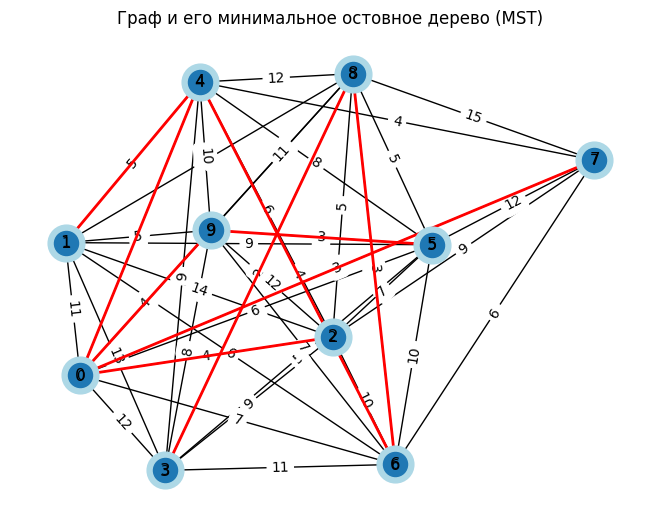

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Загрузка данных и удаление лишних пробелов
def main():
    df = pd.read_csv('lab4.csv', delimiter=';')  # Используем запятую, если данные на самом деле разделены запятой
    # Убираем пробелы в названиях столбцов
    df.columns = df.columns.str.strip()

    # Создаем отображение городов на индексы
    cities = list(set(df['City 1']).union(set(df['City 2'])))
    city_to_index = {city: idx for idx, city in enumerate(cities)}

    rebra = []
    for index, row in df.iterrows():
        # Получаем индексы городов из таблицы
        u = city_to_index[row['City 1']]
        v = city_to_index[row['City 2']]
        ves = row['Cost']
        rebra.append((u, v, ves))

    kol_vo = len(city_to_index)  # Количество уникальных городов
    ostovnye_rebra, obshchaya_stoimost = algorithm(kol_vo, rebra)

    print("Ребра с минимальной стоимостью:")
    for u, v, ves in ostovnye_rebra:
        # Находим города по их индексам
        city_u = list(city_to_index.keys())[u]
        city_v = list(city_to_index.keys())[v]
        print(f"{city_u} - {city_v}, Стоимость: {ves}")
    print("Итоговая стоимость:", obshchaya_stoimost)

    risuem_graf(kol_vo, rebra, ostovnye_rebra)

class Glav:
    def __init__(self, kol_vo):
        self.bashnya = list(range(kol_vo))
        self.rang = [0] * kol_vo

    def nayti(self, u):
        if self.bashnya[u] != u:
            self.bashnya[u] = self.nayti(self.bashnya[u])
        return self.bashnya[u]

    def soedinit(self, u, v):
        koren_u = self.nayti(u)
        koren_v = self.nayti(v)

        if koren_u != koren_v:
            if self.rang[koren_u] > self.rang[koren_v]:
                self.bashnya[koren_v] = koren_u
            elif self.rang[koren_u] < self.rang[koren_v]:
                self.bashnya[koren_u] = koren_v
            else:
                self.bashnya[koren_v] = koren_u
                self.rang[koren_u] += 1

def algorithm(kol_vo, rebra):
    nm = Glav(kol_vo)
    ostovnye_rebra = []
    obshchaya_stoimost = 0

    rebra.sort(key=lambda x: x[2])  # Сортируем по стоимости

    for u, v, ves in rebra:
        if nm.nayti(u) != nm.nayti(v):
            nm.soedinit(u, v)
            ostovnye_rebra.append((u, v, ves))
            obshchaya_stoimost += ves

    return ostovnye_rebra, obshchaya_stoimost

def risuem_graf(kol_vo, rebra, ostovnye_rebra):
    G = nx.Graph()
    G.add_weighted_edges_from(rebra)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=10, font_color='black')
    metki_reb = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=metki_reb)

    mst = nx.Graph()
    mst.add_weighted_edges_from(ostovnye_rebra)
    nx.draw(mst, pos, edge_color='red', width=2, with_labels=True)

    plt.title("Граф и его минимальное остовное дерево (MST)")
    plt.show()

if __name__ == "__main__":
    main()


#Задача 5

5. Разработать программу решения задачи о максимальном потоке. Как (т.е. по каким маршрутам) послать максимально возможное количество грузов из начального пункта в конечный пункт, если пропускная способность путей между пунктами ограничена?

##с датасетом

Имена столбцов: ['City 1', 'City 2', 'Cost']
общий максимальный поток: 16
Поток от City A к City B: 5
Поток от City A к City C: 7
Поток от City A к City D: 4
Поток от City B к City D: 5
Поток от City C к City D: 7


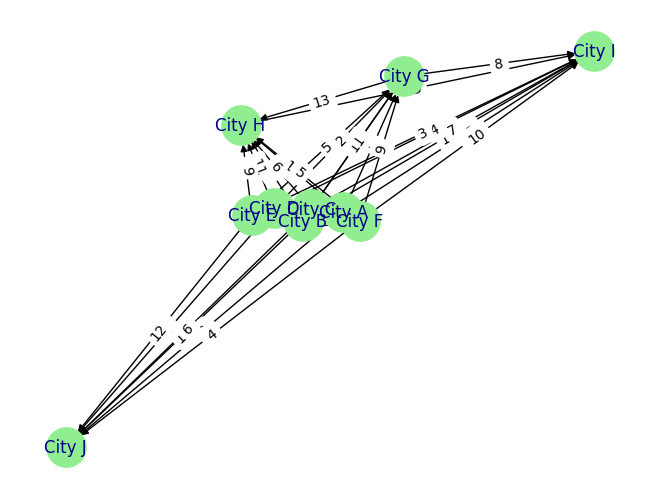

In [97]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def sozdanie_grafa(dataname):
    G = nx.DiGraph()

    # Читаем данные из CSV файла с правильным разделителем
    data = pd.read_csv(dataname, delimiter=';')

    # Выводим имена столбцов для проверки
    print("Имена столбцов:", data.columns.tolist())

    # Убираем лишние пробелы из названий столбцов, если они есть
    data.columns = data.columns.str.strip()

    # Создаем граф на основе датафрейма
    for index, row in data.iterrows():
        G.add_edge(row['City 1'], row['City 2'], capacity=row['Cost'])

    return G

def maksimalnyy_potok(G, istochnik, priznak):
    potok, slovar_potoka = nx.maximum_flow(G, istochnik, priznak)
    return potok, slovar_potoka

def risovanie_grafa(G, slovar_potoka):
    pozitsii = nx.spring_layout(G)
    nx.draw(G, pozitsii, with_labels=True, node_color='lightgreen', node_size=800, font_size=12, font_color='darkblue')

    metki_reber = nx.get_edge_attributes(G, 'capacity')
    nx.draw_networkx_edge_labels(G, pozitsii, edge_labels=metki_reber)

    for u, v in slovar_potoka.items():
        for target, potok in v.items():
            if potok > 0:
                metki_reber[(u, target)] = f"{metki_reber[(u, target)]} (P: {potok})"
    nx.draw_networkx_edge_labels(G, pozitsii, edge_labels=metki_reber)

    plt.grid(True)
    plt.show()

def osnovnoy():
    dataname = 'lab4.csv'  # Укажите путь к вашему CSV-файлу
    G = sozdanie_grafa(dataname)
    istochnik = 'City A'
    priznak = 'City D'  # Замените на ваш конечный пункт

    potok, slovar_potoka = maksimalnyy_potok(G, istochnik, priznak)

    print("общий максимальный поток:", potok)
    for u in slovar_potoka:
        for v in slovar_potoka[u]:
            if slovar_potoka[u][v] > 0:
                print(f"Поток от {u} к {v}: {slovar_potoka[u][v]}")

    risovanie_grafa(G, slovar_potoka)

if __name__ == "__main__":
    osnovnoy()


#Задача 6

6. Разработать программу решения задачи о назначениях. Имеется некоторое число работ и некоторое число исполнителей. Любой исполнитель может быть назначен на выполнение любой (но только одной) работы, но с неодинаковыми затратами. Нужно распределить работы так, чтобы выполнить их с минимальными затратами.

##с датасетом

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab6.csv', sep=";")
dataset = dataset.dropna(axis=1, how='all')
dataset.head()

,Worker,Task,Cost
0,Worker 1,Task 1,15
1,Worker 1,Task 2,20
2,Worker 1,Task 3,25
3,Worker 1,Task 4,30
4,Worker 1,Task 5,18


In [100]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

def main():
    # Загрузка данных из CSV файла
    data = pd.read_csv('lab6.csv', sep=';')

    # Преобразование в матрицу затрат
    stoimosti = data.pivot(index='Worker', columns='Task', values='Cost').fillna(0).values

    # Применение алгоритма
    ryad, kolonna = linear_sum_assignment(stoimosti)

    # Нахождение общей минимальной стоимости
    minim_stoimost = stoimosti[ryad, kolonna].sum()

    print("Распределения:")
    for r, c in zip(ryad, kolonna):
        print(f"{data['Worker'].unique()[r]} назначен на {data['Task'].unique()[c]} с затратами {stoimosti[r, c]}")

    print(f"\nОбщие минимальные затраты: {minim_stoimost}")

if __name__ == "__main__":
    main()


Распределения:
Worker 1 назначен на Task 6 с затратами 18
Worker 2 назначен на Task 4 с затратами 12
Worker 3 назначен на Task 2 с затратами 17
Worker 4 назначен на Task 1 с затратами 12
Worker 5 назначен на Task 3 с затратами 15
Worker 6 назначен на Task 10 с затратами 14
Worker 7 назначен на Task 9 с затратами 18
Worker 8 назначен на Task 8 с затратами 19
Worker 9 назначен на Task 7 с затратами 23
Worker 10 назначен на Task 5 с затратами 21

Общие минимальные затраты: 169


#Задача 7

7. Разработать программу о назначении целей. Найти оптимальное распределение комплекта различного вооружения для поражения целей для нанесения максимального поражения противнику.

##с датасетом

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab7.csv', sep=";")
dataset = dataset.dropna(axis=1, how='all')
dataset.head()

,Weapon,Target,Effectiveness
0,Weapon 1,Target 1,85
1,Weapon 1,Target 2,70
2,Weapon 1,Target 3,90
3,Weapon 1,Target 4,50
4,Weapon 1,Target 5,60


Оптимальное распределение:
Вооружение Weapon 1 назначено на цель Target 3 с уроном 89.0
Вооружение Weapon 2 назначено на цель Target 2 с уроном 93.0
Вооружение Weapon 3 назначено на цель Target 5 с уроном 88.0
Вооружение Weapon 4 назначено на цель Target 4 с уроном 92.0
Вооружение Weapon 5 назначено на цель Target 1 с уроном 99.0

Общий максимальный урон: 461.0


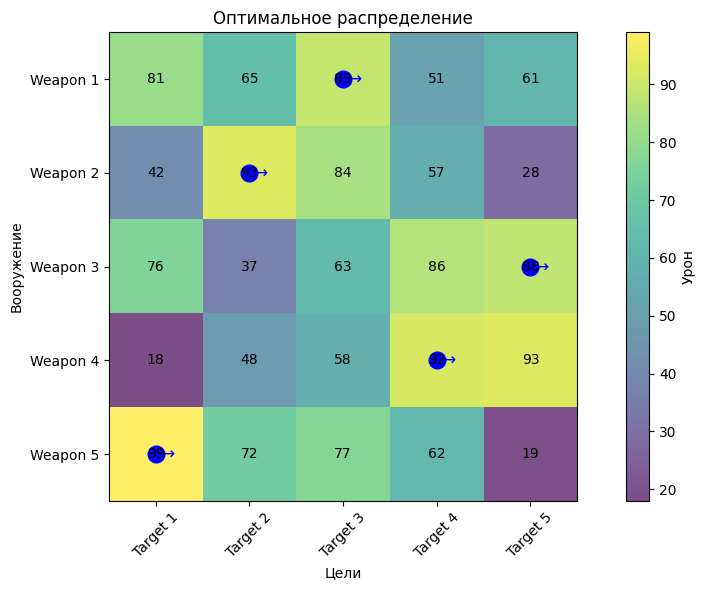

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

def main():
    # Загрузка данных из CSV
    df = pd.read_csv('lab7.csv', sep=';')

    # Создание матрицы урона
    weapons = df['Weapon'].unique()
    targets = df['Target'].unique()

    # Инициализация матрицы урона
    damage_matrix = np.zeros((len(weapons), len(targets)))

    # Заполнение матрицы урона
    for index, row in df.iterrows():
        weapon_index = np.where(weapons == row['Weapon'])[0][0]
        target_index = np.where(targets == row['Target'])[0][0]
        damage_matrix[weapon_index, target_index] = row['Effectiveness']

    # Строим матрицу стоимости (для минимизации)
    cost_matrix = -damage_matrix

    # Решаем задачу о назначении
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    max_damage = damage_matrix[row_ind, col_ind].sum()

    print("Оптимальное распределение:")
    for r, c in zip(row_ind, col_ind):
        print(f"Вооружение {weapons[r]} назначено на цель {targets[c]} с уроном {damage_matrix[r, c]}")

    print(f"\nОбщий максимальный урон: {max_damage}")

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.imshow(damage_matrix, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Урон')

    for i in range(damage_matrix.shape[0]):
        for j in range(damage_matrix.shape[1]):
            plt.text(j, i, int(damage_matrix[i, j]), ha='center', va='center')

    for r, c in zip(row_ind, col_ind):
        plt.plot(c, r, 'bo', markersize=12)
        plt.text(c, r, ' →', color='blue', fontsize=12, ha='left', va='center')

    plt.xticks(np.arange(damage_matrix.shape[1]), targets, rotation=45)
    plt.yticks(np.arange(damage_matrix.shape[0]), weapons)
    plt.title('Оптимальное распределение')
    plt.xlabel('Цели')
    plt.ylabel('Вооружение')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


#Задача 8

8. Разработать программу решения задачи о загрузке (ранце).
Из заданного множества предметов со свойствами «стоимость» и «вес» требуется отобрать некое число предметов таким образом, чтобы получить максимальную суммарную стоимость при одновременном соблюдении ограничения на суммарный вес.


##с датасетом

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab8.csv', sep=";")
dataset = dataset.dropna(axis=1, how='all')
dataset.head()

,Item ID,Cost,Weight
0,1,60,10
1,2,100,20
2,3,120,30
3,4,80,15
4,5,30,5


In [106]:
import pandas as pd

def ryukzak(vesy, stoimosti, vmeschayemost):
    kolichestvo = len(stoimosti)
    T = [[0 for _ in range(vmeschayemost + 1)] for _ in range(kolichestvo + 1)]

    for i in range(1, kolichestvo + 1):
        for w in range(vmeschayemost + 1):
            if vesy[i - 1] <= w:
                T[i][w] = max(T[i - 1][w], T[i - 1][w - vesy[i - 1]] + stoimosti[i - 1])
            else:
                T[i][w] = T[i - 1][w]

    return T[kolichestvo][vmeschayemost]

if __name__ == "__main__":
    # Считываем данные из CSV-файла
    df = pd.read_csv('lab8.csv', sep=';')

    # Извлекаем весы и стоимости из датафрейма
    veсhy = df['Weight'].tolist()
    stoimosti = df['Cost'].tolist()

    # Задаем вместимость
    vmeschayemost = 50  # Например, можно задать вместимость 50

    maksimalnaya_stoimost = ryukzak(veсhy, stoimosti, vmeschayemost)
    print(f"Максимальная стоимость, которую можно получить: {maksimalnaya_stoimost}")


Максимальная стоимость, которую можно получить: 580


#Задача 9

9. Разработать программу решения задачи о кратчайшем пути. Как кратчайшим путем (с наименьшим расходом топлива и времени, т.е. дешевле) попасть из пункта А в пункт Б?

##с датасетом

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab9.csv', sep=";")
dataset = dataset.dropna(axis=1, how='all')
dataset.head()

,From,To,Distance,Time
0,A,B,5.0,10.0
1,A,C,10.0,15.0
2,A,D,3.0,5.0
3,B,C,2.0,3.0
4,B,D,4.0,8.0


In [112]:
import heapq
import pandas as pd

def dijkstra(graf, nachalnaya_tochka, target_node):
    # Храним наименьшие стоимости до узлов
    ceny = {uzel: (float('inf'), float('inf')) for uzel in graf}
    ceny[nachalnaya_tochka] = (0, 0)  # (cost, time)
    ochered = [(0, 0, nachalnaya_tochka)]  # (cost, time, node)

    while ochered:
        tekushchaya_stoimost, tekushchee_vremya, tekushchiy_uzel = heapq.heappop(ochered)

        if tekushchaya_stoimost > ceny[tekushchiy_uzel][0] and tekushchee_vremya > ceny[tekushchiy_uzel][1]:
            continue

        for sosed, (dist, vremya) in graf[tekushchiy_uzel].items():
            novaya_stoimost = tekushchaya_stoimost + dist
            novoe_vremya = tekushchee_vremya + vremya

            if (novaya_stoimost < ceny[sosed][0]) or (novaya_stoimost == ceny[sosed][0] and novoe_vremya < ceny[sosed][1]):
                ceny[sosed] = (novaya_stoimost, novoe_vremya)
                heapq.heappush(ochered, (novaya_stoimost, novoe_vremya, sosed))

    return ceny

# Загрузка данных из CSV-файла
df = pd.read_csv('lab9.csv', sep=';')

# Создание графа из данных
graf = {}
for index, row in df.iterrows():
    from_node = row['From']
    to_node = row['To']
    distance = row['Distance']
    time = row['Time']

    if from_node not in graf:
        graf[from_node] = {}
    if to_node not in graf:
        graf[to_node] = {}

    graf[from_node][to_node] = (distance, time)
    graf[to_node][from_node] = (distance, time)  # Добавим обратное направление, если необходимо

# Задаем начальную и конечную точки
nachalnaya_tochka = 'A'
target_node = 'B'
ceny = dijkstra(graf, nachalnaya_tochka, target_node)

# Вывод результатов
final_cost, final_time = ceny[target_node]
print(f"Минимальная стоимость от {nachalnaya_tochka} до {target_node}: {final_cost}")
print(f"Минимальное время от {nachalnaya_tochka} до {target_node}: {final_time}")


Минимальная стоимость от A до B: 5.0
Минимальное время от A до B: 10.0


#Задача 10

10. Разработать программу размещения локальной сети. Найти оптимальную конфигурацию прокладки сетевого кабеля и коммутационного оборудования.

##с датасетом

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('lab10.csv', sep=";")
dataset = dataset.dropna(axis=1, how='all')
dataset.head()

,From,To,Distance,Capacity,Type
0,Node 1,Node 2,10,100,Ethernet
1,Node 1,Node 3,15,100,Ethernet
2,Node 2,Node 4,20,50,Fiber optic
3,Node 2,Node 5,25,30,Ethernet
4,Node 3,Node 6,10,100,Ethernet


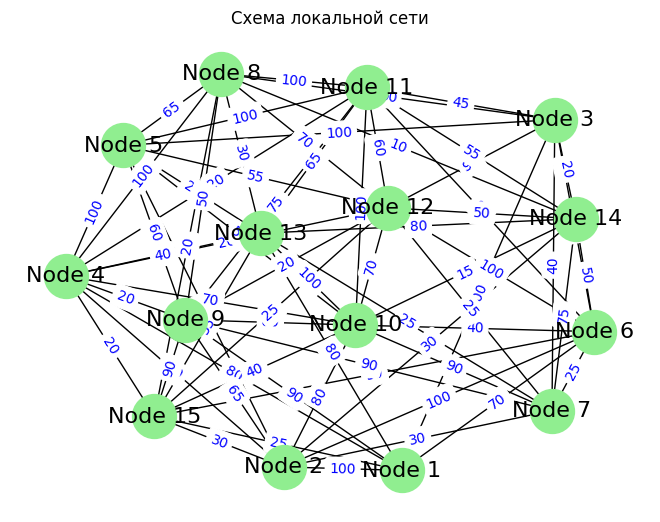

In [115]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def sozdanie_seti(svyazi):
    G = nx.Graph()

    # Добавляем узлы и ребра на основе данных
    for _, row in svyazi.iterrows():
        G.add_node(row['From'])
        G.add_node(row['To'])
        G.add_edge(row['From'], row['To'], ves=row['Capacity'])  # используем пропускную способность как вес

    return G

def risovanie_seti(G):
    pozitsii = nx.spring_layout(G)
    nx.draw(G, pozitsii, with_labels=True, node_color='lightgreen', node_size=1000, font_size=16)

    metki_reber = nx.get_edge_attributes(G, 'ves')
    nx.draw_networkx_edge_labels(G, pozitsii, edge_labels=metki_reber, font_color='blue')

    plt.title("Схема локальной сети")
    plt.show()

# Загрузка данных из CSV файла
svyazi = pd.read_csv('lab10.csv', sep=';')

# Создание сети
set = sozdanie_seti(svyazi)
risovanie_seti(set)
